# Training Data

File descriptions

    train.csv - the training set (contains 1458644 trip records)
    test.csv - the testing set (contains 625134 trip records)
    sample_submission.csv - a sample submission file in the correct format


Data fields

    id - a unique identifier for each trip
    vendor_id - a code indicating the provider associated with the trip record
    pickup_datetime - date and time when the meter was engaged
    dropoff_datetime - date and time when the meter was disengaged
    passenger_count - the number of passengers in the vehicle (driver entered value)
    pickup_longitude - the longitude where the meter was engaged
    pickup_latitude - the latitude where the meter was engaged
    dropoff_longitude - the longitude where the meter was disengaged
    dropoff_latitude - the latitude where the meter was disengaged
    store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
    trip_duration - duration of the trip in seconds
    
    #longitude range: -61 to -122, latitude range: 52-32, time range: 2016-01-01 to 2016-07-01

In [1]:
%matplotlib inline
import csv
from datetime import datetime
import numpy as np
import keras
from keras.layers import *
from keras.models import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import syslog
import time

Using TensorFlow backend.


In [2]:
print('Processing started.')
start_time = time.time()

trip = []
num = 0
maxlogi = -200; maxlati = -200
minlogi = 200; minlati = 200
with open('train.csv', newline='') as csvfile:
    R = csv.DictReader(csvfile)
    for row in R:
        item = []
        item.append(int(row['id'][2:])) #0
        item.append(int(row['vendor_id'])) #1
        item.append(datetime.strptime(row['pickup_datetime'], "%Y-%m-%d %H:%M:%S")) #2
        item.append(datetime.strptime(row['dropoff_datetime'], "%Y-%m-%d %H:%M:%S")) #3
        item.append(int(row['passenger_count'])) #4
        item.append(float(row['pickup_longitude'])) #5
        item.append(float(row['pickup_latitude'])) #6
        item.append(float(row['dropoff_longitude'])) #7
        item.append(float(row['dropoff_latitude'])) #8
        if row['store_and_fwd_flag']=='N': item.append(bool(0)) #9
        elif row['store_and_fwd_flag']=='Y': item.append(bool(1))
        item.append(int(row['trip_duration']))#10
        maxlogi = max(item[5],item[7],maxlogi)
        minlogi = min(item[5],item[7],minlogi)
        maxlati = max(item[6],item[8],maxlati)
        minlati = min(item[6],item[8],minlati)
        trip.append(item)
        
elapsed_time = time.time() - start_time
print('import training data.', elapsed_time, 'seconds.')
print('0: id, 1: vendor id, 2: picktime, 3: droptime, 4: passenger count,')
print('5: pick longitude, 6: pick latitude, 7: drop longitude, 8: drop latitude,')
print('9: store and fwd flag, 10: duration')

Processing started.
import training data. 58.77586126327515 seconds.
0: id, 1: vendor id, 2: picktime, 3: droptime, 4: passenger count,
5: pick longitude, 6: pick latitude, 7: drop longitude, 8: drop latitude,
9: store and fwd flag, 10: duration


####################REMOVE########################

#longitude range: -61 to -122, latitude range: 52-32, time range: 2016-01-01 to 2016-07-01
#print(len(trip))
#print(row.keys())
x_block = 5
y_block = 2
t_block = 183
n_block = x_block*y_block
n_input = n_block*n_block
logi_len = (maxlogi-minlogi)/x_block
lati_len = (maxlati-minlati)/y_block
mintime = datetime.strptime('2016-1-1 0:0:0', "%Y-%m-%d %H:%M:%S")

def block(logi, lati):
    x = int((logi-minlogi)/logi_len)
    y = int((lati-minlati)/lati_len)
    if x==x_block: x = x-1
    if y==y_block: y = y-1

    return y*x_block+x

#adjacency matrice, 183*24*100
#date from 0101 to 0107, time 0-23 stands for every hours
#there are 10 blocks in the map, and each people traveling is counted in 10*10=100 array 
aj = np.zeros((t_block, 24, n_input))
for t in trip:
    orig = block(t[5], t[6])
    dest = block(t[7], t[8])
    date = (t[2]-mintime).days
    time = t[2].hour
    aj[date][time][orig+dest*n_block] += t[4]

In [15]:
start_time = time.time()

#longitude range: -61 to -122, latitude range: 52-32, time range: 2016-01-01 to 2016-07-01
#print(len(trip))
#print(row.keys())

w_block = 26
mintime = datetime.strptime('2016-1-1 0:0:0', "%Y-%m-%d %H:%M:%S")
logi_len = (maxlogi-minlogi)/5; lati_len = (maxlati-minlati)/2
minlogi = minlogi+3*logi_len; maxlogi = minlogi+logi_len
maxlati = minlati+lati_len

logi_len = logi_len/3; lati_len = lati_len/3
x_block = 3; y_block = 3
n_block = x_block*y_block
n_input = 100

# return 0-8 and 9
def block(logi, lati):
    if (logi>minlogi) and (logi<maxlogi) and (lati>minlati) and (lati<maxlati):
        x = int((logi-minlogi)/logi_len)
        y = int((lati-minlati)/lati_len)
        return y*x_block+x
    else:
        return 9

#adjacency matrice, 26*7*100
#26 weeks, 7 days
#there are 10 blocks in the map, and each people traveling is counted in 10*10=100 array 
aj = np.zeros((26, 7, n_input))
for t in trip:
    orig = block(t[5], t[6])
    dest = block(t[7], t[8])
    date = (t[2]-mintime).days
    week, weekday= divmod(date, 7)
    if week<26:
        aj[week][weekday][orig+dest*n_block] += t[4]
    
elapsed_time = time.time() - start_time
print('generate adjacency matrice.', elapsed_time, 'seconds.')

generate adjacency matrice. 2.732102632522583 seconds.


In [82]:
start_time = time.time()

# 26*7*100 to 26*20
inpE = Input((7, n_input))
outE = LSTM(units = 20, return_sequences=False, activation='tanh')(inpE)
encoder = Model(inpE,outE) 

# 26*5 to 26*700 to 26*7*100
inpD = Input((20,))
outD = Reshape((20,1))(inpD)
outD = LSTM(7*n_input,return_sequences=False, activation='tanh')(outD)
outD = Reshape((7,n_input))(outD)
autoencoder = Model(inpD,outD)

autoencoder.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

autoencoder.fit(epochs=50,steps_per_epoch=10,batch_size=256)

elapsed_time = time.time() - start_time
start_time = time.time()
print('train model.', elapsed_time, 'seconds.')

AttributeError: 'NoneType' object has no attribute 'shape'

In [68]:
start_time = time.time()

#encode
encoderPredictions = encoder.predict(aj)
#decode
decoderPredictions = decoder.predict(encoderPredictions)

elapsed_time = time.time() - start_time
start_time = time.time()
print('predict.', elapsed_time, 'seconds.')

predict. 0.4208669662475586 seconds.


In [70]:
print(aj.shape, encoderPredictions.shape, decoderPredictions.shape)

(26, 7, 100) (26, 20) (26, 7, 100)


In [69]:
start_time = time.time()

aj_re = aj.reshape(-1, 700)

pca = PCA(.95)
pca_aj = pca.fit_transform(aj_re)

elapsed_time = time.time() - start_time
start_time = time.time()
print('pca on adjacency matrice.', elapsed_time, 'seconds.')

pca on adjacency matrice. 0.009664058685302734 seconds.


In [71]:
print(pca_aj.shape, pca.n_components_)

(26, 3) 3


In [72]:
start_time = time.time()

pcainv_aj = pca.inverse_transform(pca_aj)
pcainv_aj = pcainv_aj.reshape(-1, 7, 100)
print(pcainv_aj.shape)

elapsed_time = time.time() - start_time
start_time = time.time()
print('pca inverse on adjacency matrice.', elapsed_time, 'seconds.')

(26, 7, 100)
pca inverse on adjacency matrice. 0.0007107257843017578 seconds.


In [73]:
#pca.explained_variance_

dist = np.linalg.norm(decoderPredictions-aj)
base = np.linalg.norm(pcainv_aj-aj)

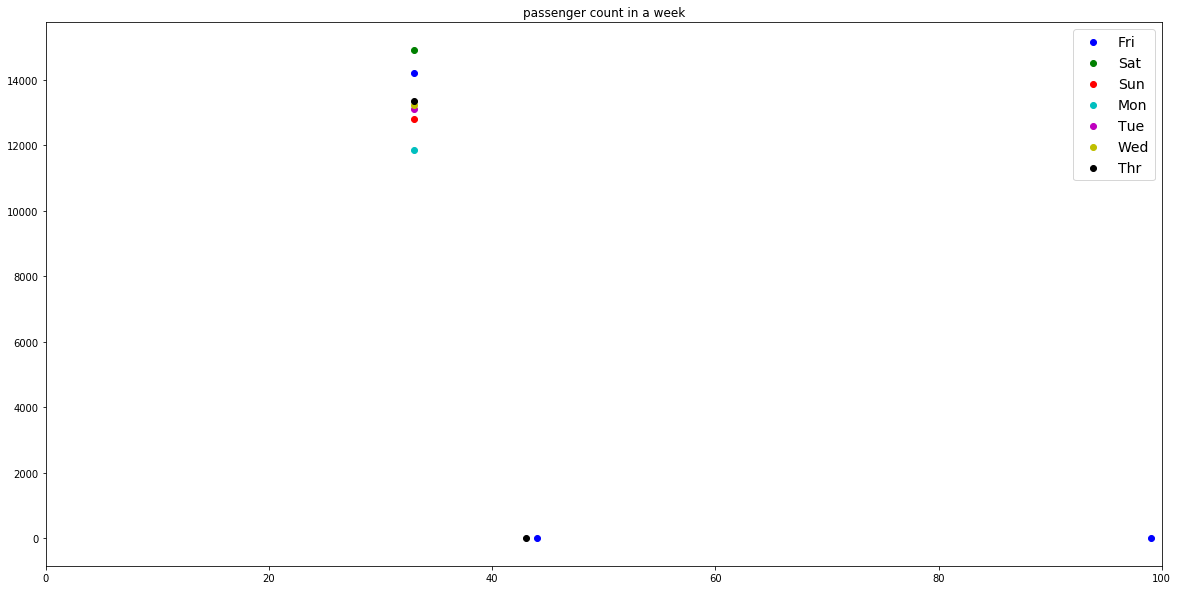

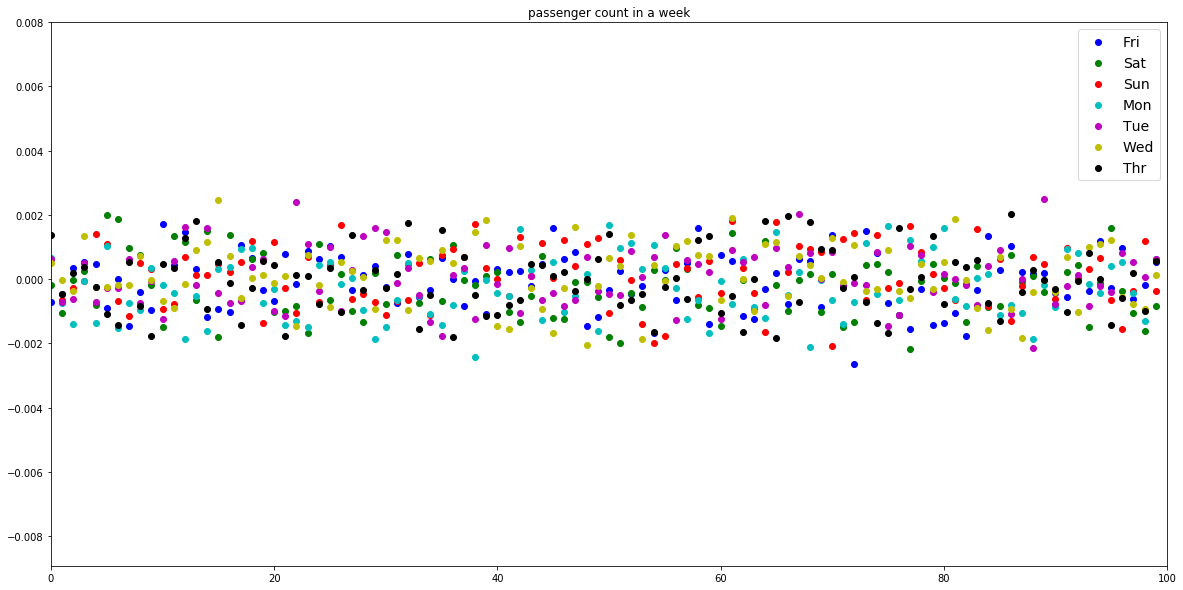

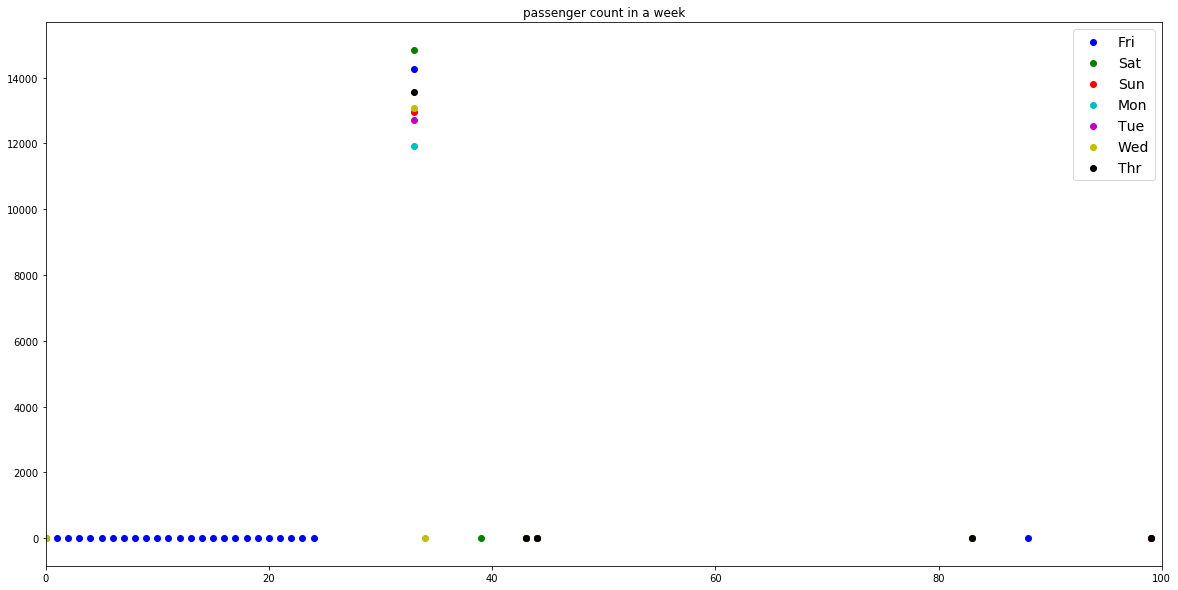

In [64]:
def plot_aj(aj_matrix, week):
    x = np.arange(100)
    fig = plt.figure(figsize=(20,10))
    color_code = ['b','g','r','c','m','y','k']
    day_code = ['Fri','Sat','Sun','Mon','Tue','Wed','Thr']
    for i in range(7):
        y = aj_matrix[week][i]
        y[ y==0 ] = np.nan
        plt.scatter(x, y, color=color_code[i], marker='o', label=day_code[i])
    plt.title('passenger count in a week')
    plt.xlim(0, 100)
    plt.legend(fontsize=14)

temp_week = 12
plot_aj(aj, temp_week)
plot_aj(decoderPredictions, temp_week)
plot_aj(pcainv_aj, temp_week)

### reference

Taxi data: https://www.kaggle.com/c/nyc-taxi-trip-duration/data

Using LSTM: https://blog.keras.io/building-autoencoders-in-keras.html

            https://stackoverflow.com/questions/44647258/lstm-autoencoder

In [ ]:
resize
normalize
reconstruction error
hidden layer 10 
visualize